<a href="https://colab.research.google.com/github/cgurkan/fake-news/blob/main/FakeNewsPreprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install text-hammer
#!pip install cleantext

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt 
import seaborn as sns
import math

BASE_URL = "/content/drive/MyDrive/Colab Notebooks/fakenews/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df_train = pd.read_csv(BASE_URL+"data/train/Task3_english_training.csv")
df_train.head()

In [ ]:
df_test = pd.read_csv(BASE_URL+"data/test/English_data_test_release_with_rating.csv")
df_test.head()

In [6]:
print(f"Training Data Shape: {df_train.shape}\nTest Data Shape: {df_test.shape}")

Training Data Shape: (900, 4)
Test Data Shape: (612, 4)


In [7]:
#Drop public_id column bot train and test dataset
df_train.drop(labels='public_id', axis=1, inplace=True)
df_test.drop(labels='ID', axis=1, inplace=True)

In [8]:
#Rename target column to "label"
df_train.rename(columns={"our rating":"label"}, inplace=True)
df_test.rename(columns={"our rating":"label"}, inplace=True)

In [9]:
df_train['label'] = df_train.label.map({'TRUE': 1, 'True':1, 'FALSE': 0, 'false':0, 'partially false': 2, 'Partially false': 2, 'other': 3, 'Other': 3})
df_train["label_name"] = df_train.label.map({0: 'False', 1:'True', 2:'Partially False',  3:'Other'})

In [10]:
df_test['label'] = df_test.label.map({'TRUE': 1, 'True':1, 'FALSE': 0, 'false':0, 'partially false': 2, 'Partially false': 2, 'other': 3, 'Other': 3})
df_test["label_name"] = df_test.label.map({0:'False', 1:'True', 2:'Partially False',  3:'Other'})

In [12]:
#clear NaN values with space, we don't use title
df_train['title'] = df_train['title'].replace(math.nan,' ')
df_test['title'] = df_test['title'].replace(math.nan,' ')
#concatenate text and title columns
df_train["news"] = df_train["title"] + ' ' + df_train["text"]
df_test["news"] = df_test["title"] + ' ' + df_test["text"]

In [13]:
df_train['num_words'] = df_train['news'].apply(lambda x:len(x.split()))

# Data Preprocessing

## Cleaning

In [14]:
import text_hammer as th

In [ ]:
%%time
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df, col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_stopwords(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

In [16]:
cleaned_df = text_preprocessing(df_train, "news")

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

In [17]:
cleaned_df_test = text_preprocessing(df_test, "news")

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

  0%|          | 0/612 [00:00<?, ?it/s]

In [18]:
#cleaned_df['num_words'] = cleaned_df['news'].apply(lambda x: len(x.split()))

# Modelling

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report , confusion_matrix,accuracy_score,f1_score,roc_curve
from xgboost import XGBClassifier
import xgboost as xgb

#Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go 

In [20]:
X_train,X_test,y_train,y_test = cleaned_df.news, cleaned_df_test.news, cleaned_df.label, cleaned_df_test.label

In [21]:
X_train.shape, X_test.shape

((900,), (612,))

In [22]:
vectorizer = TfidfVectorizer()
vector =  vectorizer.fit_transform(X_train)
x_train=vector.toarray()

vector2 = vectorizer.transform(X_test)
x_test=vector2.toarray()

In [25]:
x_train.shape, x_test.shape

((900, 27750), (612, 27750))

In [30]:
import multiclassroccurve as mc
from multiclassroccurve import plot_multiclass_roc_curves

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['False', 'True', 'Partially False', 'Other']

## NaiveBayes

In [28]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
mnb.score(x_train,y_train),mnb.score(x_test,y_test)

(0.5188888888888888, 0.5147058823529411)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.51      1.00      0.68       315
           1       0.00      0.00      0.00       210
           2       0.00      0.00      0.00        56
           3       0.00      0.00      0.00        31

    accuracy                           0.51       612
   macro avg       0.13      0.25      0.17       612
weighted avg       0.26      0.51      0.35       612



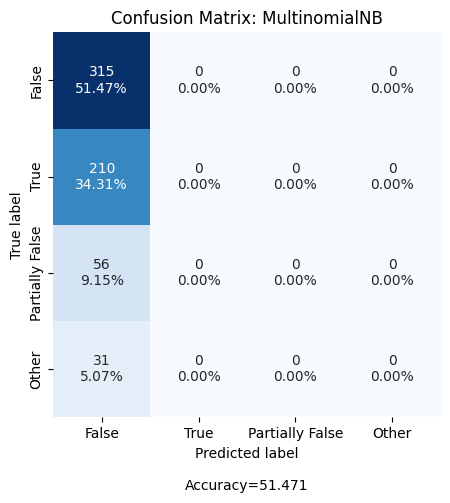

In [31]:
y_pred=mnb.predict(x_test)
print(classification_report(y_test,y_pred))
cf_matrix_1 = confusion_matrix(y_test, y_pred)
mc.make_confusion_matrix(cf_matrix_1, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5), cbar=False, title='Confusion Matrix: MultinomialNB')

In [ ]:
y_proba=mnb.predict_proba(x_test)

mc.plot_multiclass_roc_curves(mnb.classes_, categories, cleaned_df_test, y_proba, y_test)

## Decision Tree classifier

In [42]:
dtclf = DecisionTreeClassifier()
dtclf.fit(x_train, y_train)
print(dtclf.score(x_train, y_train))
print(dtclf.score(x_test,y_test))

0.9988888888888889
0.42483660130718953


In [ ]:
#confusion matrix and classification report
y_pred=dtclf.predict(x_test)
print(classification_report(y_test, y_pred))
cf_matrix_2 = confusion_matrix(y_test, y_pred)
#sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='summer', fmt='g')
mc.make_confusion_matrix(cf_matrix_2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False, title='Confusion Matrix: DecisionTreeClassifier')

In [ ]:
y_proba=dtclf.predict_proba(x_test)

mc.plot_multiclass_roc_curves(dtclf.classes_, categories, cleaned_df_test, y_proba, y_test)

## RandomForest

In [44]:
rfclf = RandomizedSearchCV(RandomForestClassifier(),{'n_estimators':[4,5],'criterion':['entropy'],'max_depth':range(1,4),'min_samples_split':range(2,5)},random_state=12)
rfclf.fit(x_train, y_train)
print('Training score:',rfclf.score(x_train, y_train))
print('Testing score:',rfclf.score(x_test,y_test))
print(rfclf.best_estimator_)

Training score: 0.5288888888888889
Testing score: 0.5163398692810458
RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=5)


In [ ]:
#confusion matrix and classification report
y_pred=rfclf.predict(x_test)
print(classification_report(y_test,y_pred))
cf_matrix_3 = confusion_matrix(y_test, y_pred)
mc.make_confusion_matrix(cf_matrix_3, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False, title='Confusion Matrix: RandomForestClassifier')

In [ ]:
y_proba=rfclf.predict_proba(x_test)

mc.plot_multiclass_roc_curves(rfclf.classes_, categories, cleaned_df_test, y_proba, y_test)

## GradientBoosting Classifier

In [50]:
#gbclf = RandomizedSearchCV(GradientBoostingClassifier(),{"learning_rate": range(3,5),"max_depth":[200],"max_features":range(6,10,2),"n_estimators":[10]},random_state=8,n_jobs=-1)
gbclf = GradientBoostingClassifier(learning_rate=3, max_depth=200, max_features=8,n_estimators=10, random_state=0)
gbclf.fit(x_train,y_train)
print('Training score:',gbclf.score(x_train,y_train))
print('Testing score:',gbclf.score(x_test,y_test))
#gbclf.best_params_

Training score: 0.9988888888888889
Testing score: 0.4950980392156863


              precision    recall  f1-score   support

           0       0.58      0.83      0.68       315
           1       0.60      0.13      0.22       210
           2       0.13      0.18      0.15        56
           3       0.09      0.10      0.09        31

    accuracy                           0.50       612
   macro avg       0.35      0.31      0.29       612
weighted avg       0.52      0.50      0.44       612



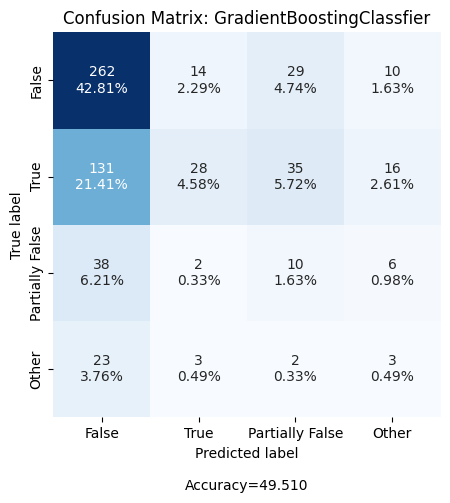

In [51]:
y_pred=gbclf.predict(x_test)
print(classification_report(y_test,y_pred))
cf_matrix_4 = confusion_matrix(y_test, y_pred)
mc.make_confusion_matrix(cf_matrix_4, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False, title='Confusion Matrix: GradientBoostingClassfier')

## XGBoost classifier

In [52]:
xgb = XGBClassifier(eval_metric='map', max_depth=200,n_estimators=70,learning_rate=1.99)
xgb.fit(x_train,y_train)
print('Training score:',xgb.score(x_train,y_train))
print('Testing score:',xgb.score(x_test,y_test))

Training score: 0.9988888888888889
Testing score: 0.48366013071895425


              precision    recall  f1-score   support

           0       0.59      0.80      0.68       315
           1       0.56      0.14      0.23       210
           2       0.12      0.21      0.15        56
           3       0.03      0.03      0.03        31

    accuracy                           0.48       612
   macro avg       0.33      0.30      0.27       612
weighted avg       0.51      0.48      0.45       612



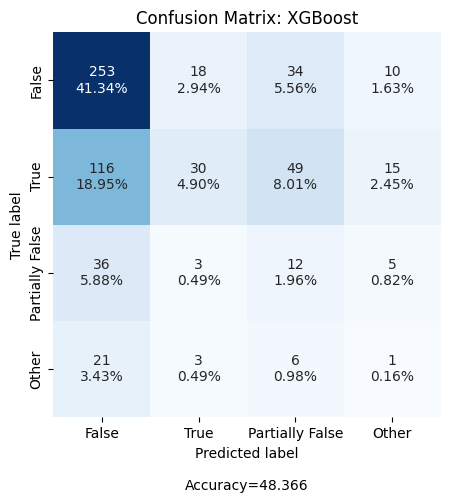

In [53]:
#confusion matrix and classification report
y_pred = xgb.predict(x_test)
print(classification_report(y_test,y_pred))
cf_matrix_5 = confusion_matrix(y_test, y_pred)
mc.make_confusion_matrix(cf_matrix_5, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False, title='Confusion Matrix: XGBoost')

[0 1 2 3]


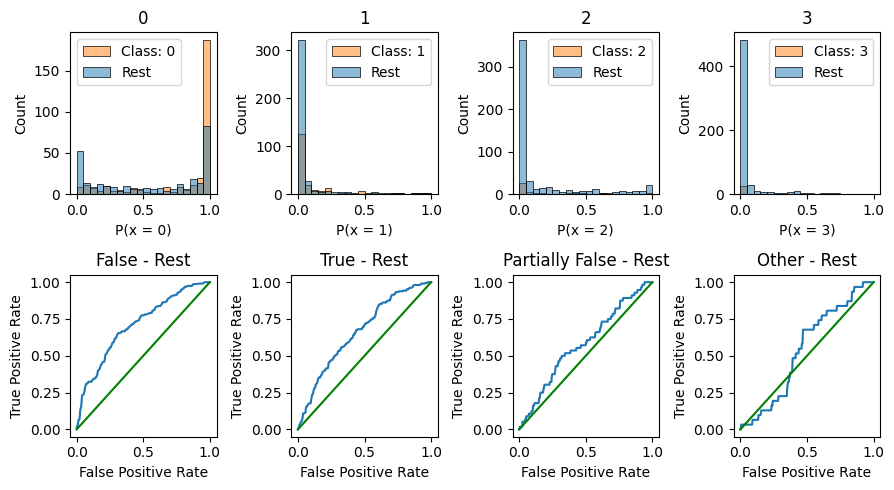

In [63]:
y_proba=xgb.predict_proba(x_test)

mc.plot_multiclass_roc_curves(xgb.classes_, categories, cleaned_df_test, y_proba, y_test)

## Ada_Boost(Random Forest)

In [54]:
RandomForest = RandomForestClassifier(criterion='entropy', max_depth=3, min_samples_split=5, n_estimators=5)
adbclf = AdaBoostClassifier(base_estimator =RandomForest,n_estimators=70,learning_rate=2.38,random_state=1)
adbclf.fit(x_train,y_train)
print('Training score:',adbclf.score(x_train,y_train))
print('Testing score:',adbclf.score(x_test,y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training score: 0.6255555555555555
Testing score: 0.4950980392156863


              precision    recall  f1-score   support

           0       0.52      0.94      0.67       315
           1       0.25      0.00      0.01       210
           2       0.14      0.09      0.11        56
           3       0.00      0.00      0.00        31

    accuracy                           0.50       612
   macro avg       0.23      0.26      0.20       612
weighted avg       0.37      0.50      0.36       612



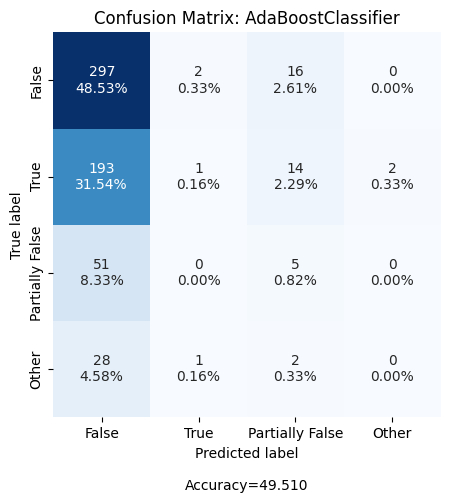

In [55]:
y_pred = adbclf.predict(x_test)
print(classification_report(y_test,y_pred))
cf_matrix_6 = confusion_matrix(y_test, y_pred)
mc.make_confusion_matrix(cf_matrix_6, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False, title='Confusion Matrix: AdaBoostClassifier')

## AddaBoost(Decision Tree)

In [56]:
Decision_tree = DecisionTreeClassifier(max_depth=200, min_samples_leaf=13, random_state=1)
adb_dt_clf = AdaBoostClassifier(base_estimator = Decision_tree,n_estimators=70,learning_rate=2,random_state=1)
adb_dt_clf.fit(x_train, y_train)
print('Training score:',adb_dt_clf.score(x_train, y_train))
print('Testing score:',adb_dt_clf.score(x_test,y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training score: 0.97
Testing score: 0.5163398692810458


              precision    recall  f1-score   support

           0       0.54      0.98      0.70       315
           1       0.00      0.00      0.00       210
           2       0.17      0.12      0.15        56
           3       0.00      0.00      0.00        31

    accuracy                           0.52       612
   macro avg       0.18      0.28      0.21       612
weighted avg       0.29      0.52      0.37       612



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


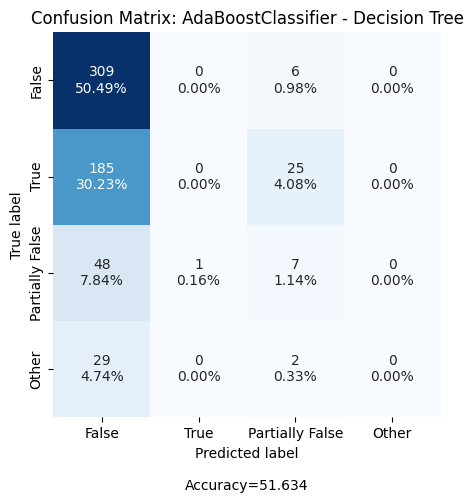

In [57]:
y_pred = adb_dt_clf.predict(x_test)
print(classification_report(y_test,y_pred))
cf_matrix_7 = confusion_matrix(y_test, y_pred)
mc.make_confusion_matrix(cf_matrix_7, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(5,5),cbar=False, title='Confusion Matrix: AdaBoostClassifier - Decision Tree')


[0 1 2 3]


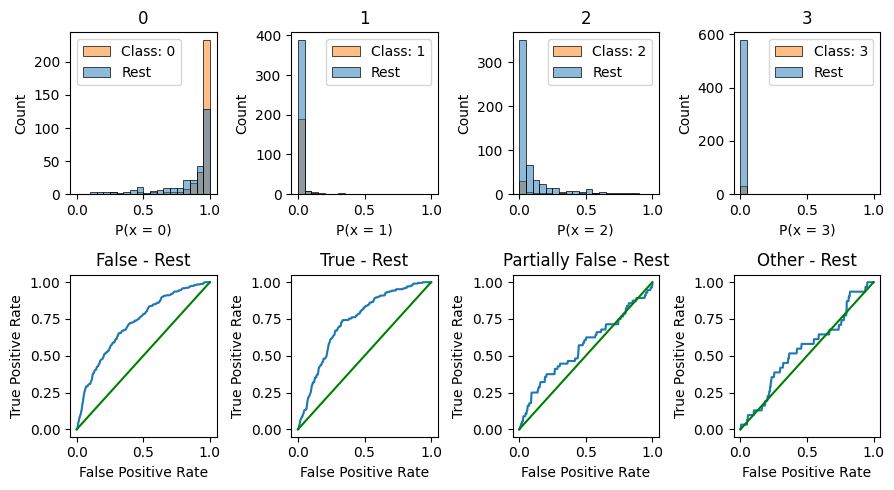

In [59]:
y_proba=adb_dt_clf.predict_proba(x_test)

mc.plot_multiclass_roc_curves(adb_dt_clf.classes_, categories, cleaned_df_test, y_proba, y_test)

In [129]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{categories[k]} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

False ROC AUC OvR: 0.7192
True ROC AUC OvR: 0.7346
Partially False ROC AUC OvR: 0.5635
Other ROC AUC OvR: 0.5444
average ROC AUC OvR: 0.6404


In [124]:
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
roc_auc_score(y_test, y_proba, labels = classes, multi_class = 'ovr', average = 'macro')

0.640441719395084